In [1]:
from __future__ import print_function

from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import numpy as np
import pandas as pd
import geopandas as gpd
import plotly.express as px

import datetime
import pickle

import matplotlib.pyplot as plt
import ndpretty

import data_prep
import gnn_prep

In [2]:
ndpretty.default()

In [3]:
data = data_prep.load_beijing_data()


Loaded air quality data from 87 devices. No weather data for []


# Analysis

## Sensors

In [4]:
def show_sensor_map(meta):
    meta_plot = meta.copy()
    meta_plot['color'] = 1
    meta_plot.loc[meta_plot['city'] == 'Beijing', 'color'] = 0

    fig = px.scatter_mapbox(meta_plot,
                            lat=meta_plot.geometry.y,
                            lon=meta_plot.geometry.x,
                            color='color',
                            color_continuous_scale=px.colors.sequential.Blackbody,
                            hover_name='city',
                            hover_data=["device_id", 'device_name'],
                            width=1000, height=700)

    fig.update_layout(
        title='Devices',
        autosize=True,
        hovermode='closest',
        showlegend=False,
        mapbox=dict(
            bearing=0,
            center=dict(
                lat=39,
                lon=117
            ),
            pitch=0,
            zoom=5,
            style='stamen-terrain'
        ),
    )

    fig.show()

show_sensor_map(data.metadata)

## Measurements

### Individual measurements

In [5]:
def get_date_slider(start=None, end=None):
    if start is None:
        start = data.measurements["time"].min().date()
    
    if end is None: 
        end = data.measurements["time"].max().date()

    days_list = pd.date_range(start, end, freq='D')
    days_list_formatted = [(date.strftime(' %d-%m-%y '), date) for date in days_list]

    ld1 = data.events[0]
    start = ld1.start - datetime.timedelta(days=14)
    end = ld1.end + datetime.timedelta(days=14)

    return widgets.SelectionRangeSlider(
        options=days_list_formatted,
        index=(0, len(days_list_formatted) - 1),
        value=(start, end),
        description='Dates',
        orientation='horizontal',
        layout={'width': '500px'}
    )

date_slider = get_date_slider()

In [6]:
devices = data.metadata['device_id']
descriptions = data.metadata['device_id'] + " (" + data.metadata['city'] + ")"
dic = dict(zip(descriptions, devices))

In [7]:
def plot_data(data, devices, date_range, feature, events=[], device_id_mapping=None):
    plt.figure(figsize=(10,5))

    # plot events
    for event in events:
        plt.axvspan(event.start, event.end, color=event.color, alpha=0.1, label=event.name)

    # plot measurements
    (start, end) = date_range
    for device in devices:
        if device_id_mapping is not None:
            device_id = device_id_mapping[device]
        else:
            device_id = device
        y = data[(data['device_id'] == device_id) & (data['time'] >= start) & (data['time'] < end)]
        plt.plot(y['time'], y[feature], label=device)

    plt.tight_layout()

    plt.title(feature)
    plt.legend(loc='upper left')
    axes = plt.gca()
    axes.set_xlim([start,end])

    plt.show()

device_widget = widgets.SelectMultiple(
    options=dic.keys(),
    rows=15,
    description='Devices',
    disabled=False
)

feature_widget = widgets.Dropdown(
    options=data.air_features,
    value='pm25',
    description='Feature:'
)

interact_manual(plot_data, data=fixed(data.measurements), devices=device_widget, date_range=get_date_slider('2020-01-01'), feature=feature_widget, events=fixed(data.events), device_id_mapping=fixed(dic))

interactive(children=(SelectMultiple(description='Devices', options=('dongsi (Beijing)', 'tiantan (Beijing)', …

<function __main__.plot_data(data, devices, date_range, feature, events=[], device_id_mapping=None)>

### City means

In [8]:
city_means = data.measurements_joined.groupby(by=['city', 'time']).mean().reset_index()
city_means = city_means.rename(columns={'city': 'device_id'})

In [9]:
city_widget = widgets.SelectMultiple(
    options=list(city_means['device_id'].unique()),
    rows=15,
    description='Devices',
    disabled=False
)

interact_manual(plot_data, data=fixed(city_means), devices=city_widget, date_range=date_slider, feature=feature_widget, events=fixed(data.events), device_id_mapping=fixed(None))

interactive(children=(SelectMultiple(description='Devices', options=('Baoding', 'Beijing', 'Cangzhou', 'Chengd…

<function __main__.plot_data(data, devices, date_range, feature, events=[], device_id_mapping=None)>

In [10]:
def show_map(measurements, time, feature):
    x = measurements[measurements['time'] == time]
    
    # x = x.merge(meta, on=['device_id', 'city'])
    x = gpd.GeoDataFrame(x)

    x["size"] = 10

    fig = px.scatter_mapbox(x,
                            lat=x.geometry.y,
                            lon=x.geometry.x,
                            hover_name='city',
                            hover_data=["device_id", 'device_name'],
                            color=feature,
                            size='size',
                            color_continuous_scale=px.colors.sequential.matter,
                            width=1000, height=700)

    fig.update_layout(
        title=f'Measurements on {time}',
        autosize=True,
        hovermode='closest',
        showlegend=False,
        mapbox=dict(
            bearing=0,
            center=dict(
                lat=39,
                lon=117
            ),
            pitch=0,
            zoom=5,
            style='stamen-terrain' # 'stamen-terrain'
        ),
    )

    fig.show()
    # plt.show()s

# interact(show_map, time=date_slider)
show_map(data.measurements_joined, '2020-04-15 00:00:00', 'pm25')

### Check for missing data

In [11]:
# select only every third hour (that's how they use it in PM2.5-GNN) - use %2==2, since we have most data for (2:00, 5:00, 8:00, etc.)
filtered_city_means = city_means[city_means['time'].dt.hour % 6 == 2]
del filtered_city_means['co']
del filtered_city_means['no2']
del filtered_city_means['o3']
del filtered_city_means['pm10']
del filtered_city_means['so2']
# filtered_city_means
missing_city_means = filtered_city_means[filtered_city_means.isnull().any(axis=1)]

There's quite a few entries, where we don't have a single measurement per city:

In [12]:
missing_city_means[missing_city_means['device_id'] == 'Beijing']

device_id                time  pm25  2m_temperature  \
45443   Beijing 2016-03-08 02:00:00   NaN      271.769394   
46433   Beijing 2016-04-18 08:00:00   NaN      285.398684   
46457   Beijing 2016-04-19 08:00:00   NaN      284.738627   
48899   Beijing 2016-07-30 02:00:00   NaN      299.468960   
49133   Beijing 2016-08-08 20:00:00   NaN      300.449057   
...         ...                 ...   ...             ...   
86267   Beijing 2020-11-03 02:00:00   NaN      273.428716   
86273   Beijing 2020-11-03 08:00:00   NaN      274.719468   
86825   Beijing 2020-11-26 08:00:00   NaN      272.198500   
87221   Beijing 2020-12-12 20:00:00   NaN      270.762279   
87671   Beijing 2020-12-31 14:00:00   NaN      273.374860   

       boundary_layer_height  relative_humidity  surface_pressure  \
45443             388.606560          10.934496     101205.089063   
46433            1651.480915          28.991673      99650.357366   
46457             267.133454          35.095757     100139.290402   
48899              62.572838          91.714913      99127.840402   
49133              48.667683          52.882216      99220.055357   
...                      ...                ...               ...   
86267              48.014408          20.539606     101157.806250   
86273              59.523493          25.276428     101333.064732   
86825              33.308629          44.905076     101797.062277   
87221              60.844371          72.742715     100246.733482   
87671            1304.379164          14.565267     101039.824777   

       total_precipitation  u_component_of_wind  v_component_of_wind  \
45443         0.000000e+00            -0.816389            -9.123912   
46433        -9.313226e-10             6.556572            -6.846524   
46457        -9.313226e-10            -1.200830             5.546798   
48899         5.561922e-05             1.379788             3.240738   
49133         0.000000e+00            -1.126268             2.318303   
...                    ...                  ...                  ...   
86267        -4.656613e-10             5.666376            -3.183477   
86273        -4.656613e-10             4.677437            -3.548727   
86825        -4.656613e-10            -3.891373             2.445123   
87221         2.432574e-04             2.575821            -4.416295   
87671         1.164153e-10             5.437479            -0.874900   

              lon        lat  
45443  116.405514  39.986543  
46433  116.405514  39.986543  
46457  116.405514  39.986543  
48899  116.405514  39.986543  
49133  116.405514  39.986543  
...           ...        ...  
86267  116.405514  39.986543  
86273  116.405514  39.986543  
86825  116.405514  39.986543  
87221  116.405514  39.986543  
87671  116.405514  39.986543  

[437 rows x 12 columns]

### Missing data

In [13]:
def analyse_missing_data(relevant):
    relevant_missing = relevant[relevant.isnull().any(axis=1)]
    
    print(f"Missing of relevant data: {len(relevant_missing) / len(relevant) * 100}%")

    missing_by_device = relevant_missing.groupby('device_id').count()
    plt.figure(figsize=(15,5))
    plt.bar(missing_by_device.index, missing_by_device['time'])
    plt.xticks(missing_by_device.index, rotation='vertical')
    plt.show()

    missing_by_time = relevant_missing.groupby(relevant_missing['time']).count()
    plt.figure(figsize=(15,5))
    plt.plot(missing_by_time.index, missing_by_time['device_id'])
    plt.show()

    return relevant_missing

In [14]:
data.measurements

co   no2    o3   pm10   pm25   so2                time device_id  \
0      2.6  78.0   2.0  118.0  106.0  22.0 2016-01-01 08:00:00    dongsi   
1      1.9  70.0   2.0    NaN   93.0  19.0 2016-01-01 09:00:00    dongsi   
2      1.7  71.0   4.0   98.0   90.0  25.0 2016-01-01 10:00:00    dongsi   
3      2.0  78.0   5.0  118.0  103.0  28.0 2016-01-01 11:00:00    dongsi   
4      2.1  78.0   7.0  123.0  119.0  32.0 2016-01-01 12:00:00    dongsi   
...    ...   ...   ...    ...    ...   ...                 ...       ...   
43836  0.8  42.0  29.0   61.0   30.0   8.0 2020-12-31 20:00:00     1080A   
43837  0.7  50.0  21.0   62.0   28.0   8.0 2020-12-31 21:00:00     1080A   
43838  0.7  57.0  13.0   58.0   27.0   9.0 2020-12-31 22:00:00     1080A   
43839  0.8  62.0   8.0   60.0   27.0  10.0 2020-12-31 23:00:00     1080A   
43840  1.1  62.0   8.0   89.0    NaN  11.0 2021-01-01 00:00:00     1080A   

       2m_temperature  boundary_layer_height  relative_humidity  \
0          267.751068              21.074707          63.814396   
1          267.351410              48.319824          63.284851   
2          272.813538             137.124756          60.066856   
3          273.494934             250.302979          56.321255   
4          274.482422             333.806152          57.764404   
...               ...                    ...                ...   
43836      269.864899             183.958252          16.240383   
43837      269.329865             118.362549          14.960537   
43838      268.356262              80.671631          13.558804   
43839      266.548401              54.295654          11.848537   
43840             NaN                    NaN                NaN   

       surface_pressure  total_precipitation  u_component_of_wind  \
0         102244.796875        -2.328306e-10             2.000273   
1         102278.046875        -2.328306e-10             2.529001   
2         102232.640625        -2.328306e-10             3.063230   
3         102179.554688        -2.328306e-10             3.184820   
4         102029.265625        -2.328306e-10             3.293757   
...                 ...                  ...                  ...   
43836     101490.617188         1.164153e-10             4.418459   
43837     101455.164062         1.164153e-10             4.459060   
43838     101418.445312         1.164153e-10             3.865332   
43839     101379.195312         1.164153e-10             2.940588   
43840               NaN                  NaN                  NaN   

       v_component_of_wind  
0                -0.097951  
1                -0.434698  
2                -1.120642  
3                -1.384467  
4                -1.037642  
...                    ...  
43836             6.952785  
43837             4.670843  
43838             2.768245  
43839             1.280961  
43840                  NaN  

[3814167 rows x 15 columns]

Missing of relevant data: 7.339183477957685%


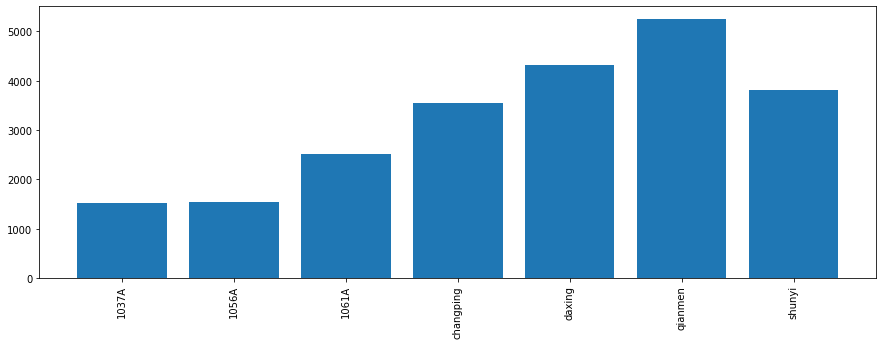

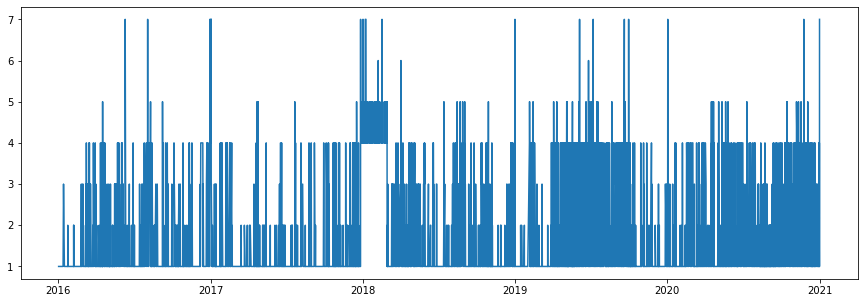

device_id  pm25                time  2m_temperature  \
100      daxing   NaN 2016-01-05 12:00:00      271.792755   
101      daxing   NaN 2016-01-05 13:00:00      274.189850   
204      daxing   NaN 2016-01-09 20:00:00      271.390381   
266      daxing   NaN 2016-01-12 10:00:00      268.385681   
677      daxing   NaN 2016-01-29 13:00:00      271.467804   
...         ...   ...                 ...             ...   
43687     1061A   NaN 2020-12-25 15:00:00      273.397583   
43688     1061A   NaN 2020-12-25 16:00:00      272.021118   
43692     1061A   NaN 2020-12-25 20:00:00      263.864288   
43837     1061A   NaN 2020-12-31 21:00:00      259.220459   
43840     1061A   NaN 2021-01-01 00:00:00             NaN   

       boundary_layer_height  relative_humidity  surface_pressure  \
100               885.485718          32.774979     102796.734375   
101              1085.186157          35.026993     102673.296875   
204                27.480957          34.825264     102233.921875   
266               626.802979          32.183361     103238.023438   
677              1159.852905          31.758564     103307.734375   
...                      ...                ...               ...   
43687            1061.779663          24.614597      90403.453125   
43688             705.284180          25.795406      90403.453125   
43692              15.458252          40.852619      90544.625000   
43837              79.142578          26.597214      90852.937500   
43840                    NaN                NaN               NaN   

       total_precipitation  u_component_of_wind  v_component_of_wind  
100          -2.328306e-10             2.705610            -0.467898  
101          -2.328306e-10             3.037371             0.406577  
204          -2.328306e-10             1.628899             0.909919  
266          -2.328306e-10             5.240310           -10.105507  
677          -2.328306e-10            -3.176962             1.731630  
...                    ...                  ...                  ...  
43687         1.164153e-10             2.512129            -1.902899  
43688         1.164153e-10             1.498063            -1.165797  
43692         1.164153e-10            -1.173473            -1.386862  
43837         1.164153e-10             1.209080            -1.849922  
43840                  NaN                  NaN                  NaN  

[22523 rows x 10 columns]

In [15]:
rel_fields = ['device_id', 'pm25', 'time', '2m_temperature', 'boundary_layer_height', 'relative_humidity', 'surface_pressure', 'total_precipitation', 'u_component_of_wind', 'v_component_of_wind'
            ]
rel_devices = [ 'qianmen', 'changping', 'daxing', 'shunyi', # Beijing
                '1056A', # Baoding
                # '1069A', # Langfang
                '1061A', # Zhangjiakou
                '1037A', # Tangshan
                ]

relevant = data.measurements[rel_fields]
relevant = relevant[relevant['device_id'].isin(rel_devices)]

relevant_missing = analyse_missing_data(relevant)
relevant_missing

In [16]:
show_sensor_map(data.metadata)

Super surrounding
- Baoding (south-west)
- Langfang (south-east)
- Zhangjiakou (north)
- Tangshan (east)

In the area:
- Shijiazhuang (south-west)

Beijing:
- qianmen (center)
- changping (north)
- daxing (south)
- shunyi (north-east)

### Analyse GNN results

Couldn't load R.npy for 'PM25_GNN_before': [Errno 2] No such file or directory: 'Previous work/PM2.5-GNN/data/results/0_336/1/PM25_GNN/20210313115717/00/R.npy'


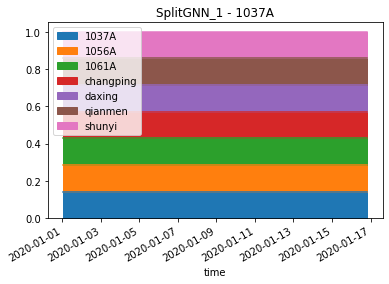

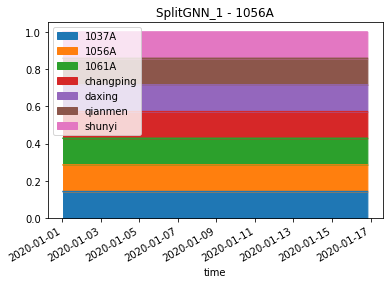

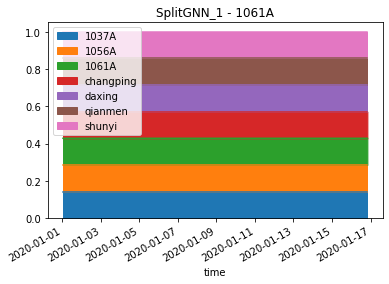

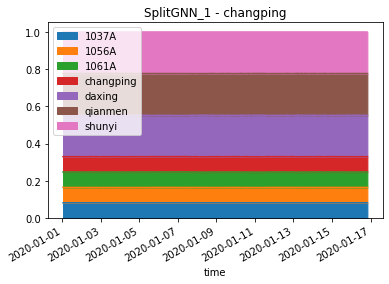

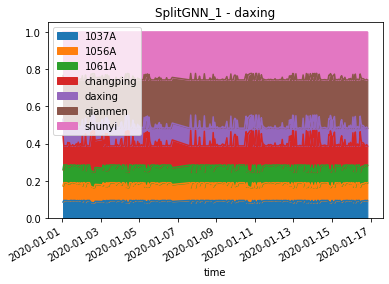

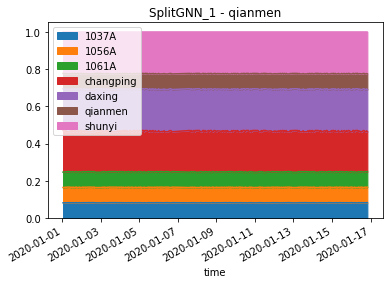

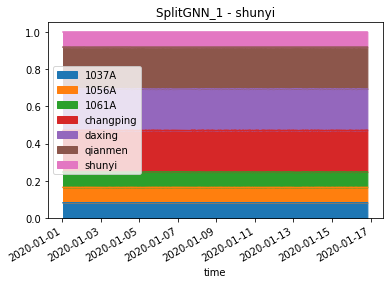

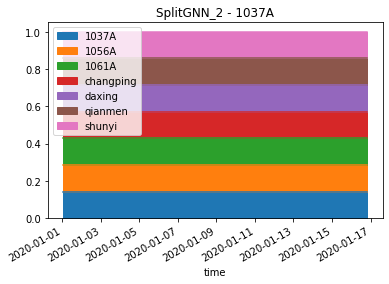

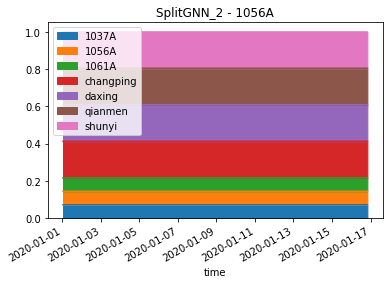

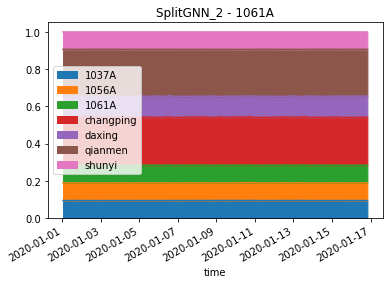

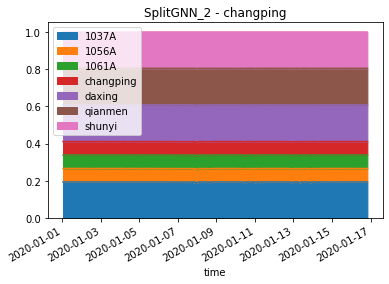

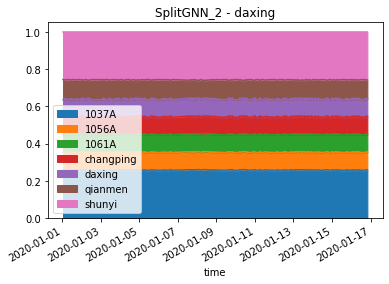

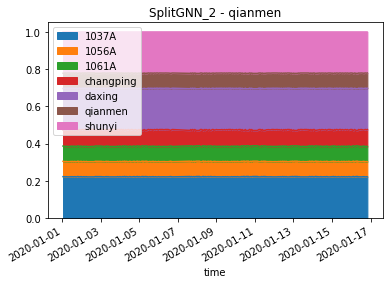

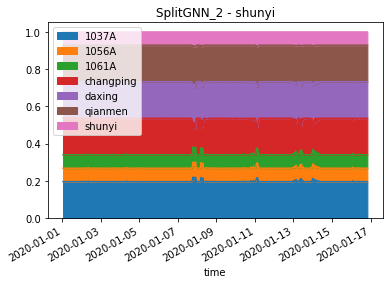

interactive(children=(SelectMultiple(description='Devices', options=('1037A', '1037A - PM25_GNN_DS1', '1037A -…

In [18]:
def plot_gnn_results(df):
    devices = list(df['device_id'].unique())
    devices.sort()

    device_widget = widgets.SelectMultiple(
        options=devices,
        rows=15,
        description='Devices',
        disabled=False
    )

    interact_manual(plot_data, data=fixed(df), devices=device_widget, date_range=get_date_slider('2020-01-01'), feature=fixed('pm25'), events=fixed(data.events), device_id_mapping=fixed(None))

def load_gnn_preds(devices, result_path, start_date, exp_name):
    time_npy = np.load(result_path + 'time.npy')
    pred_npy = np.load(result_path + 'predict.npy')

    preds = gnn_prep.transform_preds_back(time_npy, pred_npy, devices, start_date, melted=True)

    try:
        R_npy = np.load(result_path + 'R.npy')
        if R_npy.shape[0] > 0: # skip models without R predictions
            for device_id in devices:
                gnn_prep.plot_R(time_npy, R_npy, devices, device_id, start_date, exp_name)
    except FileNotFoundError as e:
        print(f"Couldn't load R.npy for '{exp_name}': {e}")

    preds['time'] = preds.index
    return preds


def plot_with_start(start_date, experiments, dataset_name, gnn_data_path="Previous work/PM2.5-GNN/data/"):
    # load devices for dataset
    devices_path = f"{gnn_data_path}city_{dataset_name}.txt"
    city_txt = pd.read_csv(devices_path, sep=' ', header=None, index_col=0)
    devices = list(city_txt[1])

    df = data.measurements.copy()
    df.index = df['time']
    df = df[df['device_id'].isin(devices)]

    # load experimental predictions
    for exp_name, exp_path in experiments.items():
        preds = load_gnn_preds(devices, gnn_data_path + 'results/' + exp_path, start_date, exp_name)
        preds['device_id'] = preds['device_id'].apply(lambda x: x + " - " + exp_name)
        df = df.append(preds)

    plot_gnn_results(df)

dataset_name = "DS1"
experiments = {
    "PM25_GNN_before": "0_336/1/PM25_GNN/20210313115717/00/",
    "PM25_GNN_DS1_error": "0_336/1/PM25_GNN/20210323110234/00/",
    "PM25_GNN_DS1": "0_336/1/PM25_GNN/20210324071946/00/",
    "SplitGNN_1": "0_336/1/SplitGNN_1/20210324072142/00/",
    "SplitGNN_2": "0_336/1/SplitGNN_2/20210324072237/00/"
}

plot_with_start('2020-01-01 01:00:00', experiments, dataset_name)